# Analisi di immagini binarie.

## Importazione delle librerie.

In [2]:
import numpy as np
import cv2 as cv
import va

L'analisi di immagini binare è alla base di molti processi di rilevamento e riconoscimento di oggetti.

Esempi:
- Il risultato di tecniche di elaborazione è costituiro da immagini binarie.
- Applicazioni di riconoscimento del testo, conteggio e misura di oggetti necessitano di lavorare su immagini binarie.

## Topologia digitale.

Disciplina che studia proprietà e caratteristiche topologiche delle immagini (componenti connesse, bordi di un oggetto, etc...).

Considera immagini binarie, ovvero, immagini composte da soli due colori:
- background $F^{*} = \{p | p = [x,y]^{T}, Img[y,x] = 0 \} $.
- foreground $F = \{p | p = [x,y]^{T}, Img[y,x] \neq 0 \} $.

### Metriche e distanze

Le metriche più comuni sono basate su:

- distanza $d_{4} : d_{4}(p,q) = |x_{q} - x_{p}| + |y_{q} - y_{p}|$.
- distanza $d_{8} : d_{8}(p,q) = max\{|x_{q} - x_{p}|, |y_{q} - y_{p}|\}$.

<br>
<div>
    <img src="notebook_immagini_spiegazioni/metriche.png" />
</div>

I **vicini** di un pixel $p$ sono quelli aventi distanza unitaria da $p$.

Un **percorso** di lunghezza $n$ da $p$ a $q$ è una sequenza di pixel $\{ p_{0} = p, p_{1}, \dots, p_{n} = q\}$ tale che, in accordo con la metrica scelta $p_{i}$ è un vicino di $p_{i+1}$ $\forall i : 0 \leq i < n$.

<br>
<div>
    <img src="notebook_immagini_spiegazioni/percorsi.png" />
</div>

Una **componente connessa** è un sottoinsieme di $F$ (o di $F^{*}$) tale che, presi due qualsiasi dei suoi pixel, esiste tra questi un percorso appartenente a F  (o ad $F^{*}$). In base alla metrica adottata si parla di 4-connessione o di 8-connessione.

## Trasformata distanza

La trasformata distanza di $F$ rispetto $F^{*}$ è una replica di $F$ in cui i **pixel sono etichettati con il valore della loro distanza da $F^{*}$**.

<br>
<div>
    <img src="notebook_immagini_spiegazioni/td.png" />
</div>

### Algoritmo sequenziale

La trasformata può essere calcolata tramite due scansioni dell'immagine:
- Scansione diretta (alto verso basso, sinistra verso destra).
- Scansione inversa (basso verso l'alto, destra verso sinistra). 

Durante le scansioni i pixel di $F$ vengono trasformati; i pixel di $F^{*}$ sono posti a zero.

- $Img^{'}[p] \quad \forall p \in F $ è calcolato come segue:
    - Scansione diretta : distanza propagata dai vicini in alto a sinistra (che sono già considerati).
       $$
           Img^{'}[p] = min\{Img^{'}[p_{0}],Img^{'}[p_{N}] \} + 1 
       $$
    - Scansione inversa: la distanza viene aggiornata tenendo conto anche dei percorsi verso il basso e a destra.
       $$
           Img^{'}[p] = min\{Img^{'}[p_{E}] + 1,Img^{'}[p_{S}] + 1, Img^{'}[p]\}
       $$


<br>
<div>
    <img src="notebook_immagini_spiegazioni/trasformata.png" />
</div>


In OpenCV è disponibile la funzione `cv.distanceTransform()` per il calcolo della trasfromata.

Immagine iniziale,Metrica d4,Metrica d8
,,

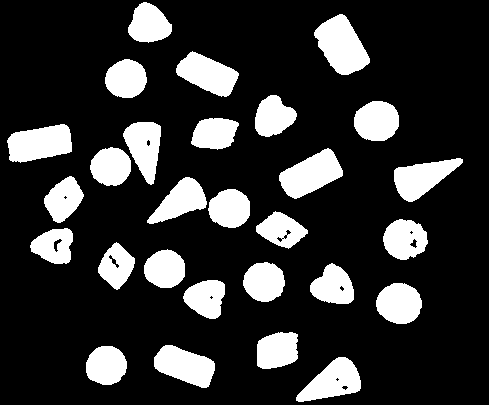
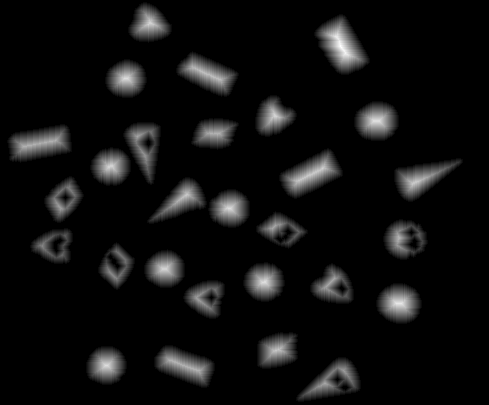
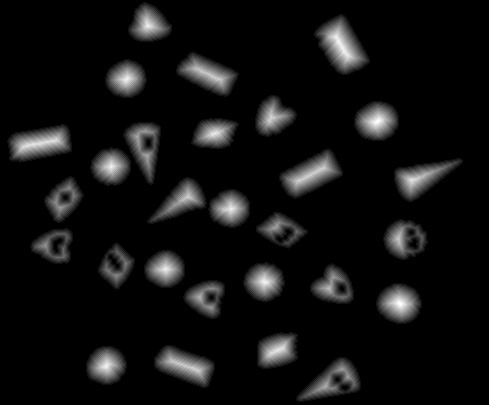

In [7]:
# Caricamento dell'immagine 
img = cv.imread("immagini/mask1_esempio.png", cv.IMREAD_GRAYSCALE)

# Trasfromata distanza con metrica d4
dt4 = cv.distanceTransform(img, cv.DIST_L1, 5)

# Trasformata distanza con metrica d8
dt8 = cv.distanceTransform(img, cv.DIST_C, 5)

va.show((img, "Immagine iniziale"), (dt4, "Metrica d4"), (dt8, "Metrica d8"))

### Applicazioni trasformata distanza

- Può essere utilizzata per la misurazione geometrica (lunghezze, spessori, etc...),

- Produce massimi locali di instensità in corrispondenza degli assi mediani dell'oggetto (scheletro).
    - Nel caso di oggetti allungati la trasformata può essere utilizzata per algoritmi di assottigliamento o
thinning.

Applicazione più avanzate della trasformata includo il template matching o la robotica (ricerca di movimento ottimale, aggiustamento ostacoli, $\dots$).


## Estrazione del contorno 

Il contorno di $F$ è costituito dalla sequenza ordinata dei pixel che hanno distanza unitaria da $F^{*}$ (in base alla metrica adottata).
Per l'estrazione del controno di un oggette viene impegata una tecnica di inseguimento che percorre il bordo nella stessa direzione, fino a tornare al pixel di partenza. 

In Python si adopera la funzione `cv.findContours()`

Possiamo memorizzare il contorno:
- Con una lista ordinata di pixel (`cv.CHAIN_APPROX_NONE`). 
- Una lista dei vertici dei segmenti che lo compongono (`cv.CHAIN_APPROX_SIMPLE`). 
- Approssimandolo con una serie di curve (`cv.CHAIN_APPROX_TC89_L1, cv.CHAIN_APPROX_TC89_KCOS`). 

,,,
,,,

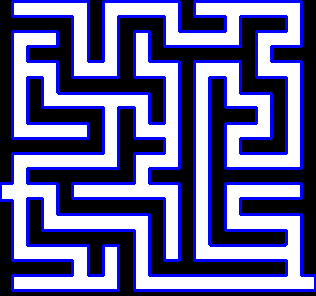
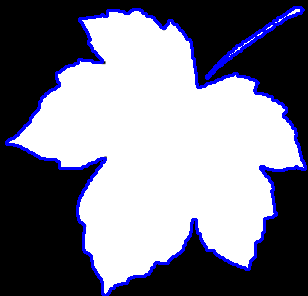
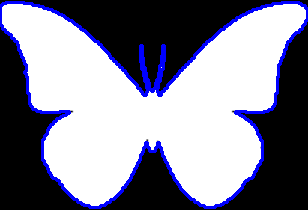
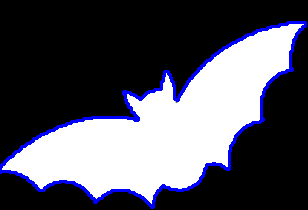

In [16]:
esempi = ('labyrinth', 'leaf', 'butterfly', 'bat')
res = []
for n in esempi:
    
    img = cv.imread('immagini/' + n + '.png', cv.IMREAD_GRAYSCALE)
    c, _ = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    res.append(cv.drawContours(cv.cvtColor(img, cv.COLOR_GRAY2BGR), c, -1, (255,0,0), 2))
    
va.show(*res)

Immagine di partenza,Immagine binarizzata,
,,

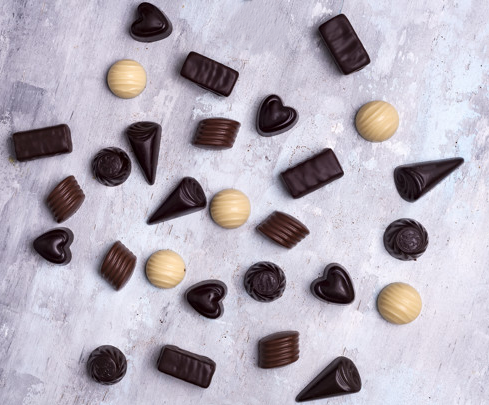
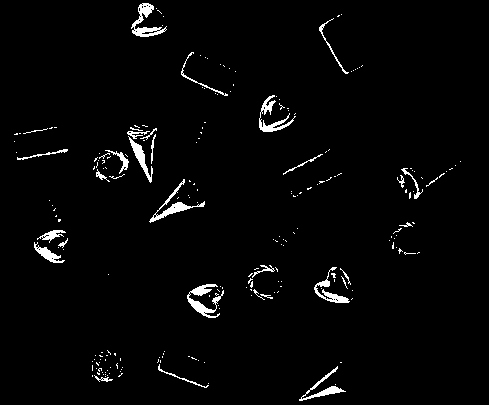
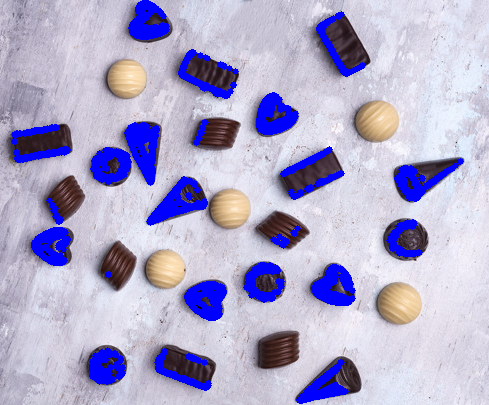

In [37]:
# Estrazione del contorno in OpenCV
img = cv.imread("immagini/pralines.png")
img_g = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# Binarizzo, l'immagine 
_, b = cv.threshold(img_g,20,255, cv.THRESH_BINARY_INV)

# La funzione restituisce anche una struttura dati ad albero che contiene 
# eventuali relazioni fra contoeni (contorno padre che contiene uno o più "figli")
contours, tree = cv.findContours(b, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

c1 = cv.drawContours(img.copy(), contours, -1, (255,0,0), 5)


va.show((img, "Immagine di partenza"), (b, "Immagine binarizzata"), c1)
